# Simultaneous fits: Combining likelihoods with shared parameters

This is a topical tutorial. If you are new to iminuit, you should go through the basic tutorial first.

This notebook demonstrates how to simultaneously fit two datasets, where the distributions have a parameter.

In [1]:
from iminuit import Minuit
from iminuit.cost import UnbinnedNLL
from iminuit.util import make_with_signature, describe
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# norm_pdf from numba_stats is a compiled function
# without a function signature, so we create one
from numba_stats import norm_pdf

print(f"before {describe(norm_pdf)=}")
normal_pdf = make_with_signature(norm_pdf, "x", "μ", "σ")
print(f"after  {describe(normal_pdf)=}")

before describe(norm_pdf)=()
after  describe(normal_pdf)=('x', 'μ', 'σ')


In [7]:
# generate two data sets which are fitted simultaneously
rng = np.random.default_rng(1)

width = 2.0
data1 = rng.normal(0, width, size=1000)
data2 = rng.normal(5, width, size=1000)

In [8]:
# rename non-shared parameters so that they are fitted independently
pdf1 = make_with_signature(normal_pdf, μ='μ_1')
pdf2 = make_with_signature(normal_pdf, μ='μ_2')

# combine two log-likelihood functions by adding them
lh = UnbinnedNLL(data1, pdf1) + UnbinnedNLL(data2, pdf2)

print(f"{describe(lh)=}")

describe(lh)=('μ_1', 'σ', 'μ_2')


The `σ` parameter is shared between the data sets, while the means of the two normal distributions are independently fitted.

In [9]:
def plot(cost, xe, minuit, ax, **style):
    signature = list(describe(cost))
    data = cost.data
    
    values = minuit.values[signature]
    errors = minuit.errors[signature]

    cx = (xe[1:] + xe[:-1]) / 2
    dx = (xe[1] - xe[0])

    ym = normal_pdf(cx, *values) * np.sum(w * dx)
    t = []
    for n, v, e in zip(signature, values, errors):
        t.append(f"${n} = {v:.3f} ± {e:.3f}$")
    ax.plot(cx, ym, label="\n".join(t), **style)

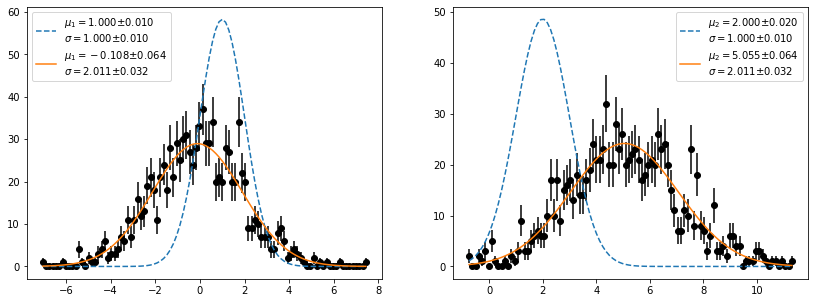

In [12]:
m = Minuit(lh, μ_1=1, μ_2=2, σ=1)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

hists = [np.histogram(lhi.data, bins=100) for lhi in lh]

# draw data and model with initial parameters
for lhi, (w, xe), axi in zip(lh, hists, ax):
    cx = (xe[1:] + xe[:-1]) / 2
    axi.errorbar(cx, w, np.sqrt(w), fmt="ok", capsize=0, zorder=0)
    plot(lhi, xe, m, axi, ls="--")

m.migrad()

# draw model with fitted parameters
for lhi, (w, xe), axi in zip(lh, hists, ax):
    plot(lhi, xe, m, axi)
    axi.legend()

The dashed line shows the initial model before the fit, the solid line shows the model after the fit. Note that the σ parameter is shared.